<a href="https://colab.research.google.com/github/BernardoRMendes/Projeto/blob/main/MetaLabeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import sklearn as sklearn
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

**Em finanças, não basta sabermos a direção de determinado ativo. Para ter ganhos consistentes no longo prazo, precisamos saber qual será o tamanho da posição. Em geral, os modelos que indicam compra ou venda não são úteis para determinar o position sizing. Para isso, podemos criar um modelo secundário com o objetivo de mostrar em quais momentos (e consequentemente calibrar a posição) nosso modelo primário deve ser aplicado.**

**Usando um exemplo concreto, suponha que já temos um modelo de Trend-Following aplicado ao milho. Esse modelo tem uma taxa de acerto ao redor de 40%. No entanto, sabemos que variáveis exógenas influenciam o preço do milho, como por exemplo a cotação do dólar, volatilidade, preço do petróleo, curva de juros, estrutura a termo dos futuros de milho, sazonalidade, entre outros inúmeros fatores. Então, podemos criar um modelo secundário que indique quando nossa estratégia de Trend-Following tem maior assertividade, reduzindo o número de falso-positivos.**

**No exemplo a seguir, utilizei uma estratégia de Trend-Following no CCMFUT (Milho) no período entre 2016 à 2019. Atribuí "1" quando o retorno foi positivo e "0" quando negativo. Em seguida, criei 6 atributos não utilizados no modelo primário, mas que possuem relação com a dinâmica de preços do milho. A parte de Engenharia de Atributos (Feature Engineering) é a etapa do processo de Machine Learning com maior potencial para geração de alpha. Logo, por motivos óbvios, não vou revelar quais são os atributos desse estudo. Os atributos ainda foram transformados em variáveis Dummy (0 ou 1).**

**Para esse estudo, criaremos o Meta-Modelo com o algoritmo de Floresta Aleatória (Random Forest).**

In [2]:
url="https://raw.githubusercontent.com/BernardoRMendes/Projeto/main/MetaLabeling.xlsx"

In [3]:
df=pd.read_excel(url,index_col=0)

In [4]:
df.head()

,Retorno,Sucesso/Fracasso,Atributo1,Atributo2,Atributo3,Atributo4,Atributo5,Atributo6
Trade,,,,,,,,
1,0.103820,1,0,0,0,0,1,0
2,0.016335,1,0,0,0,0,1,1
3,0.130632,1,0,0,1,0,1,1
4,0.012956,1,0,0,0,0,1,1
5,-0.011578,0,0,0,1,0,0,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73 entries, 1 to 73
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Retorno           73 non-null     float64
 1   Sucesso/Fracasso  73 non-null     int64  
 2   Atributo1         73 non-null     int64  
 3   Atributo2         73 non-null     int64  
 4   Atributo3         73 non-null     int64  
 5   Atributo4         73 non-null     int64  
 6   Atributo5         73 non-null     int64  
 7   Atributo6         73 non-null     int64  
dtypes: float64(1), int64(7)
memory usage: 5.1 KB


In [6]:
df.describe()

,Retorno,Sucesso/Fracasso,Atributo1,Atributo2,Atributo3,Atributo4,Atributo5,Atributo6
count,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000
mean,0.013172,0.383562,0.383562,0.273973,0.287671,0.301370,0.410959,0.383562
std,0.051010,0.489618,0.489618,0.449082,0.455810,0.462028,0.495413,0.489618
min,-0.039145,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.013639,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-0.005226,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.014731,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,0.255204,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
df.corr()

,Retorno,Sucesso/Fracasso,Atributo1,Atributo2,Atributo3,Atributo4,Atributo5,Atributo6
Retorno,1.000000,0.656921,0.037415,-0.133395,-0.112198,0.101512,0.185591,-0.099783
Sucesso/Fracasso,0.656921,1.000000,-0.100794,-0.105565,-0.127878,0.157275,0.142755,-0.158730
Atributo1,0.037415,-0.100794,1.000000,-0.168732,-0.252345,0.034483,-0.029022,0.073016
Atributo2,-0.133395,-0.105565,-0.168732,1.000000,0.084582,0.065104,-0.200965,0.020767
Atributo3,-0.112198,-0.127878,-0.252345,0.084582,1.000000,-0.153582,-0.100263,0.058824
Atributo4,0.101512,0.157275,0.034483,0.065104,-0.153582,1.000000,0.118862,-0.149706
Atributo5,0.185591,0.142755,-0.029022,-0.200965,-0.100263,0.118862,1.000000,0.085496
Atributo6,-0.099783,-0.158730,0.073016,0.020767,0.058824,-0.149706,0.085496,1.000000


In [8]:
atributos=df[["Atributo1","Atributo2","Atributo3","Atributo4","Atributo5","Atributo6"]]
target=df["Sucesso/Fracasso"]

**shuffle=False para manter a ordem das observações.**

In [9]:
atributosTrain, atributosTest, targetTrain, targetTest = train_test_split(atributos,target, test_size=0.3,shuffle=False)

In [10]:
print(atributosTrain.shape)
print(atributosTest.shape)
print(targetTrain.shape)
print(targetTest.shape)

(51, 6)
(22, 6)
(51,)
(22,)


**Veja que, no período analisado, a estratégia acerta 40% das vezes. Essa taxa está em linha com modelos tradicionais seguidores de tendência.**

In [11]:
Assertividade=round(target[target==1].count()/len(target)*100,2)
print(f'Assertividade: {Assertividade}%')

Assertividade: 38.36%


**Inicialmente, criamos o modelo de machine learning sem qualquer otimização.**

In [12]:
clf=RandomForestClassifier()
print(clf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [13]:
modelo1=clf.fit(atributosTrain, targetTrain)

**Idealmente, deveríamos testar nosso modelo em um conjunto de validação para ajuste de hiperparâmetros e, somente após atingir uma performance satisfatória, colocarmos em teste para averiguar a capacidade de generalização em um dataset não visto. Como temos poucos dados, esse ajuste de hiperparâmetros será feito no próprio conjunto de treino de forma parcimoniosa, para evitar overfitting.**

In [14]:
previsao=modelo1.predict(atributosTrain)

**Importância dos atributos no modelo inicial:**

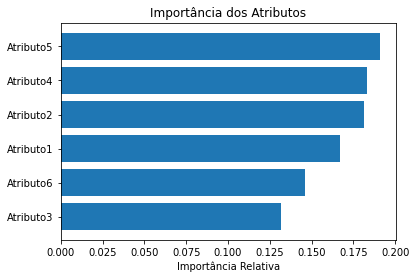

In [15]:
importancia=modelo1.feature_importances_
indices=np.argsort(importancia)
ind=[]
for i in indices:
    ind.append(atributosTrain.columns[i])
plt.figure()
plt.title('Importância dos Atributos')
plt.barh(range(len(indices)), importancia[indices])
plt.yticks(range(len(indices)),ind)
plt.xlabel('Importância Relativa')
plt.show()

**Cálculo das métricas de performance em treino:**

F1_Score: 85.71%
Recall: 90.0%
Precision: 81.82%
Acurácia: 88.24%


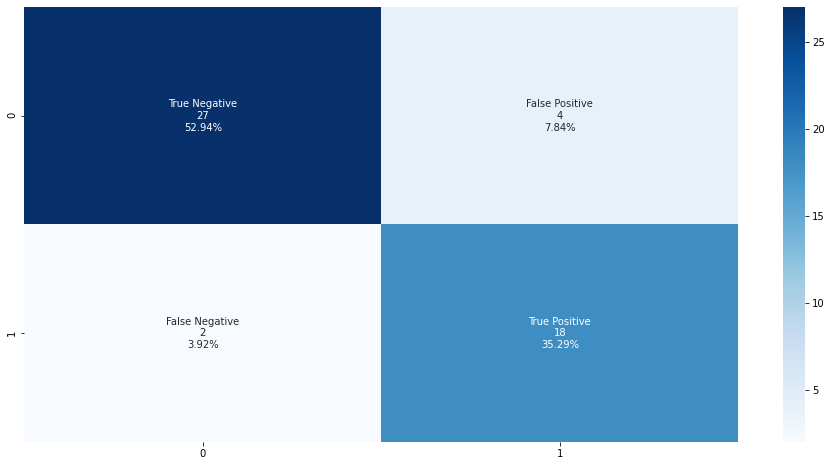

In [16]:
from sklearn.metrics import confusion_matrix
cf_matrix=confusion_matrix(targetTrain,previsao)
group_names=["True Negative","False Positive","False Negative","True Positive"]
group_counts=["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels=[f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(16,8))
sns.heatmap(cf_matrix, annot=labels, fmt='',cmap='Blues')

f1_score=round(sklearn.metrics.f1_score(targetTrain,previsao)*100,2)
print(f'F1_Score: {f1_score}%')
recall=round(sklearn.metrics.recall_score(targetTrain,previsao)*100,2)
print(f'Recall: {recall}%')
precision=round(sklearn.metrics.precision_score(targetTrain,previsao)*100,2)
print(f'Precision: {precision}%')
acuracia=round(sklearn.metrics.accuracy_score(targetTrain,previsao)*100,2)
print(f'Acurácia: {acuracia}%')

**No primeiro modelo, os scores de avaliação estão extremamente elevados, indicando Overfitting. Para mitigar esse problema, aplicaremos o GridSearch, buscando a melhor combinação de hiperparâmetros, entre as opções disponíveis.
A lista de valores possíveis que o algoritmo deve buscar foi limitada, para mitigar as changes de overfitting.**

**n_estimators: Número de árvores de decisão construídas**

**max_depth: Regula a profundidade máxima da árvore de decisão na floresta**

**max_features: subconjunto aleatório dos atributos que serão considerados quando houver divisão em um nó da árvore de decisão**


In [17]:
clf=RandomForestClassifier()

In [18]:
i=range(5)
for i in i:
  param_grid = {
                 'n_estimators': [50,100,200],
                 'max_depth': [2,3],
               'max_features':[2,3]}


  grid_clf= GridSearchCV(clf, param_grid,scoring="f1")
  grid_clf.fit(atributosTrain, targetTrain)
  print(grid_clf. best_params_)

{'max_depth': 2, 'max_features': 2, 'n_estimators': 50}
{'max_depth': 2, 'max_features': 2, 'n_estimators': 50}
{'max_depth': 3, 'max_features': 2, 'n_estimators': 50}
{'max_depth': 2, 'max_features': 3, 'n_estimators': 50}
{'max_depth': 2, 'max_features': 2, 'n_estimators': 50}


**Observe que o GridSearch indica combinações diferentes de hiperparâmetros, mostrando que não existe apenas um modelo ideal. Portanto, na escolha do modelo final, existe um componente de subjetividade, cabendo ao analista escolher um dos modelos de acordo com seu conhecimento sobre a área de negócio.**

**Criando o modelo final:**

In [19]:
clf=RandomForestClassifier(max_depth=2, max_features=3, n_estimators=100,random_state=30)

In [20]:
modelo_final=clf.fit(atributosTrain, targetTrain)

In [21]:
previsao=modelo_final.predict(atributosTrain)

**Importância dos atributos no modelo final:**

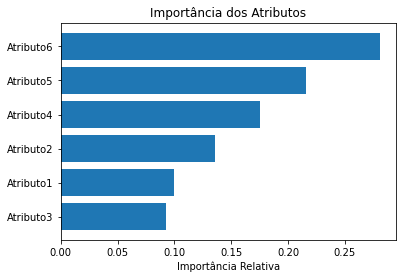

In [22]:
importancia=modelo_final.feature_importances_
indices=np.argsort(importancia)
ind=[]
for i in indices:
    ind.append(atributosTrain.columns[i])
plt.figure()
plt.title('Importância dos Atributos')
plt.barh(range(len(indices)), importancia[indices])
plt.yticks(range(len(indices)),ind)
plt.xlabel('Importância Relativa')
plt.show()

**Alterando o random_state, podemos testar novamente o modelo e verificar se há mudança na ordem de importância dos atributos. Para os valores que eu testei, os atributos 5 e 6 permaneceram como mais importantes, indicando que esses atributos são realmente importantes para nossa estratégia.**

**Cálculo das métricas de performance em treino com o modelo final:**

F1_Score: 42.86%
Recall: 30.0%
Precision: 75.0%
Acuracia: 68.63%


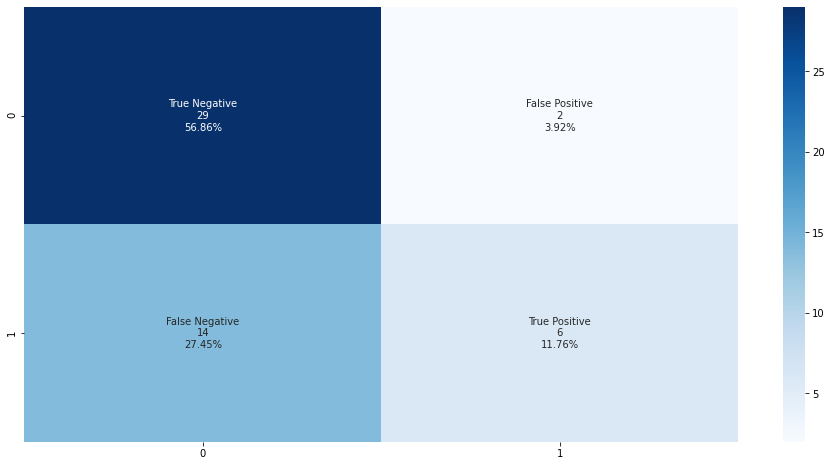

In [23]:
cf_matrix=confusion_matrix(targetTrain,previsao)
group_names=["True Negative","False Positive","False Negative","True Positive"]
group_counts=["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels=[f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(16,8))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

f1_score=round(sklearn.metrics.f1_score(targetTrain,previsao)*100,2)
print(f'F1_Score: {f1_score}%')
recall=round(sklearn.metrics.recall_score(targetTrain,previsao)*100,2)
print(f'Recall: {recall}%')
precision=round(sklearn.metrics.precision_score(targetTrain,previsao)*100,2)
print(f'Precision: {precision}%')
acuracia=round(sklearn.metrics.accuracy_score(targetTrain,previsao)*100,2)
print(f'Acuracia: {acuracia}%')

**Cálculo das métricas de performance em teste com o modelo final:**

In [24]:
previsao_teste=modelo_final.predict(atributosTest)
cf_matrix=confusion_matrix(targetTest,previsao_teste)

F1_Score: 36.36%
Recall: 25.0%
Precision: 66.67%
Acuracia: 68.18%


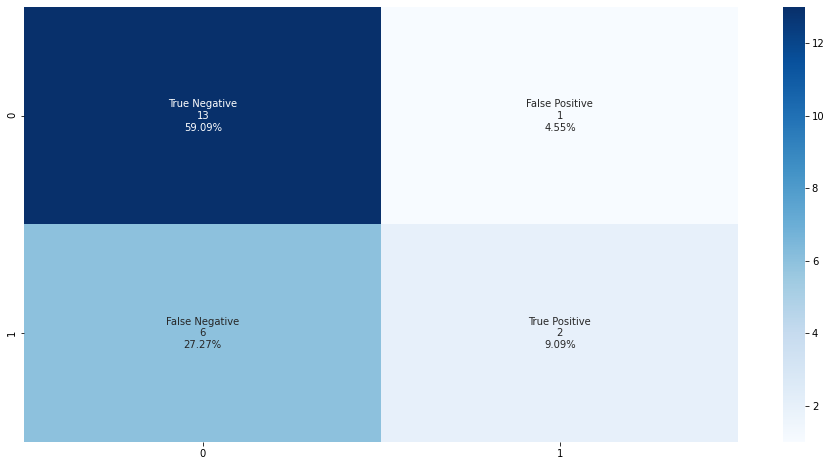

In [25]:
group_names=["True Negative","False Positive","False Negative","True Positive"]
group_counts=["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels=[f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(16,8))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

f1_score=round(sklearn.metrics.f1_score(targetTest,previsao_teste)*100,2)
print(f'F1_Score: {f1_score}%')
recall=round(sklearn.metrics.recall_score(targetTest,previsao_teste)*100,2)
print(f'Recall: {recall}%')
precision=round(sklearn.metrics.precision_score(targetTest,previsao_teste)*100,2)
print(f'Precision: {precision}%')
acuracia=round(sklearn.metrics.accuracy_score(targetTest,previsao_teste)*100,2)
print(f'Acuracia: {acuracia}%')

**Modelo Final em treino:**

**F1_Score: 42.86%**

**Recall: 30.0%**

**Precision: 75.0%**

**Acuracia: 68.63%**

**Modelo Final em teste:**

**F1_Score: 36.36%**

**Recall: 25.0%**

**Precision: 66.67%**

**Acuracia: 68.18%**

**Como as métricas de performance do modelo final em treino e teste não foram muito diferentes, temos um indicativo de que os hiperparâmetros foram modificados de forma que o modelo pudesse generalizar para novos dados sem overfitting.**

**Para cada conjunto de atributos, podemos calcular a probabilidade de o próximo trade dar certo. Como o modelo de Meta-Labeling tende a aumentar a assertividade do modelo primário, podemos tirar vantagem disso por meio do position sizing. No exemplo abaixo, quando a probabilidade de retorno positivo for maior que 50%, entraremos com o dobro da posição original e, quando for menor que 50%, entraremos com metade da posição original.**

In [26]:
#Lista de inputs
i=range(1,74)
l=list()
for i in i:
  lista=[df['Atributo1'][i],df['Atributo2'][i],df['Atributo3'][i],df['Atributo4'][i],df['Atributo5'][i],df['Atributo6'][i]]
  x=np.asarray(lista)
  clf.predict(x.reshape(1,-1))
  l.append(clf.predict_proba(x.reshape(1,-1))[0][1])

In [27]:
print(l)

[0.5498499739652519, 0.42726834677676306, 0.43131139665288276, 0.42726834677676306, 0.2245334971014536, 0.43365630763771157, 0.1522401581114328, 0.4005133237124522, 0.16447087162923069, 0.41724947434410015, 0.45171509555639316, 0.49706430226606235, 0.17004699068561288, 0.41135517622436785, 0.5611737415547317, 0.34544123896698276, 0.48936638864605264, 0.5611737415547317, 0.5611737415547317, 0.33421327936582346, 0.43683823953935996, 0.43683823953935996, 0.5474412205049404, 0.46639267524738315, 0.3464946071263207, 0.35138441000041815, 0.41311503998686, 0.49706430226606235, 0.43935832654393364, 0.15272112111613725, 0.4000434989824342, 0.1522401581114328, 0.4000434989824342, 0.15272112111613725, 0.41135517622436785, 0.41135517622436785, 0.35138441000041815, 0.5474412205049404, 0.4827941106843381, 0.48936638864605264, 0.5474412205049404, 0.35467741084165233, 0.48520778333293796, 0.43131139665288276, 0.5498499739652519, 0.47373969296956914, 0.23403540983066812, 0.35138441000041815, 0.33009485

In [28]:
df2=pd.DataFrame(l,columns=['Probabilidade'],index=df.index)
df["Probabilidade"]=df2
df["RetornoML"]=np.where(df["Probabilidade"]>0.5,2*df["Retorno"],0.5*df["Retorno"])
df["Portfolio"]=100*(1+df["Retorno"]).cumprod()
df["PortfolioML"]=100*(1+df["RetornoML"]).cumprod()

In [29]:
df2

,Probabilidade
Trade,
1,0.549850
2,0.427268
3,0.431311
4,0.427268
5,0.224533
...,...
69,0.351384
70,0.246578
71,0.311931


In [30]:
df

,Retorno,Sucesso/Fracasso,Atributo1,Atributo2,Atributo3,Atributo4,Atributo5,Atributo6,Probabilidade,RetornoML,Portfolio,PortfolioML
Trade,,,,,,,,,,,,
1,0.103820,1,0,0,0,0,1,0,0.549850,0.207640,110.382022,120.764045
2,0.016335,1,0,0,0,0,1,1,0.427268,0.008167,112.185075,121.750365
3,0.130632,1,0,0,1,0,1,1,0.431311,0.065316,126.840074,129.702632
4,0.012956,1,0,0,0,0,1,1,0.427268,0.006478,128.483416,130.542847
5,-0.011578,0,0,0,1,0,0,1,0.224533,-0.005789,126.995848,129.787141
...,...,...,...,...,...,...,...,...,...,...,...,...
69,0.010590,1,1,0,0,0,0,0,0.351384,0.005295,204.142097,277.478170
70,0.027567,1,0,1,0,0,0,1,0.246578,0.013784,209.769765,281.302846
71,0.052539,1,1,0,0,1,0,1,0.311931,0.026270,220.790943,288.692588


In [31]:
def drawdown(return_series: pd.Series):
    """Recebe uma série de retornos e
       retorna um dataframe com o valor acumulado,
       picos prévios, e o drawdown
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})

In [32]:
df3=df[["Portfolio","PortfolioML"]][-22:]
df3["Portfolio"]=df3["Portfolio"]/df3["Portfolio"][:1].values
df3["PortfolioML"]=df3["PortfolioML"]/df3["PortfolioML"][:1].values
df4=df[["Retorno","RetornoML"]][-22:]

In [33]:
Portfolio=dict()
Portfolio["Retorno"]=((df3["Portfolio"][-1:]/df3["Portfolio"][:1].values-1)*100).values[0]
Portfolio["Max Drawdown"]=drawdown(df4["Retorno"]).Drawdown.min()*100
Portfolio["Calmar"]=abs(Portfolio["Retorno"]/Portfolio["Max Drawdown"])
Portfolio=pd.DataFrame.from_dict(Portfolio.items())
Portfolio=Portfolio.set_index(0)
Portfolio.index.name=None
Portfolio.columns=["Portfolio"]
PortfolioML=dict()
PortfolioML["Retorno"]=((df3["PortfolioML"][-1:]/df3["PortfolioML"][:1].values-1)*100).values[0]
PortfolioML["Max Drawdown"]=drawdown(df4["RetornoML"]).Drawdown.min()*100
PortfolioML["Calmar"]=abs(PortfolioML["Retorno"]/PortfolioML["Max Drawdown"])
PortfolioML=pd.DataFrame.from_dict(PortfolioML.items())
PortfolioML=PortfolioML.set_index(0)
PortfolioML.index.name=None
PortfolioML.columns=["PortfolioML"]
portfolio=pd.concat([PortfolioML,Portfolio],axis=1)

**PERFORMANCE DO MODELO APENAS NO DATASET DE TESTE:**

**Apesar de o modelo com utilização de Machine Learning ter tido retorno levemente inferior na amostra de teste, o retorno ajustado ao risco foi melhor, pois reduzimos o Drawdown praticamente pela metade, indicando que o processo de Meta-Labeling realmente melhorou a assertividade do modelo primário, além de auxiliar no position sizing.**

In [34]:
portfolio

,PortfolioML,Portfolio
Retorno,36.784456,39.136749
Max Drawdown,-5.621832,-10.990699
Calmar,6.543144,3.560897


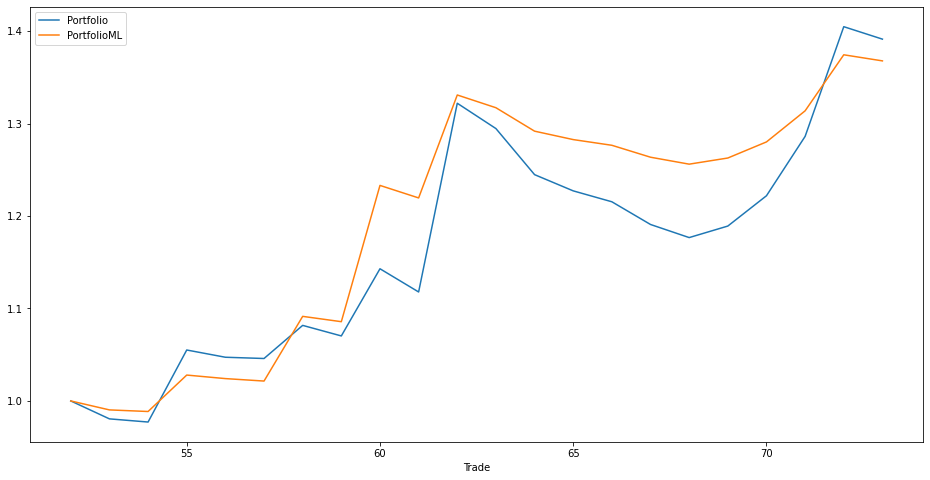

In [35]:
df3[["Portfolio","PortfolioML"]].plot(figsize=(16,8))

In [36]:
Portfolio=dict()
Portfolio["Retorno Anualizado"]=((df["Portfolio"][-1:].values[0]/100)**(1/4)-1)*100
Portfolio["Max Drawdown"]=drawdown(df["Retorno"]).Drawdown.min()*100
Portfolio["Calmar"]=abs(Portfolio["Retorno Anualizado"]/Portfolio["Max Drawdown"])
Portfolio=pd.DataFrame.from_dict(Portfolio.items())
Portfolio=Portfolio.set_index(0)
Portfolio.index.name=None
Portfolio.columns=["Portfolio"]
PortfolioML=dict()
PortfolioML["Retorno Anualizado"]=((df["PortfolioML"][-1:].values[0]/100)**(1/4)-1)*100
PortfolioML["Max Drawdown"]=drawdown(df["RetornoML"]).Drawdown.min()*100
PortfolioML["Calmar"]=abs(PortfolioML["Retorno Anualizado"]/PortfolioML["Max Drawdown"])
PortfolioML=pd.DataFrame.from_dict(PortfolioML.items())
PortfolioML=PortfolioML.set_index(0)
PortfolioML.index.name=None
PortfolioML.columns=["PortfolioML"]
portfolio=pd.concat([PortfolioML,Portfolio],axis=1)

**PERFORMANCE DO MODELO CONSIDERANDO A AMOSTRA TODA:**

In [37]:
portfolio

,PortfolioML,Portfolio
Retorno Anualizado,31.669250,24.317516
Max Drawdown,-14.903970,-19.127532
Calmar,2.124887,1.271336


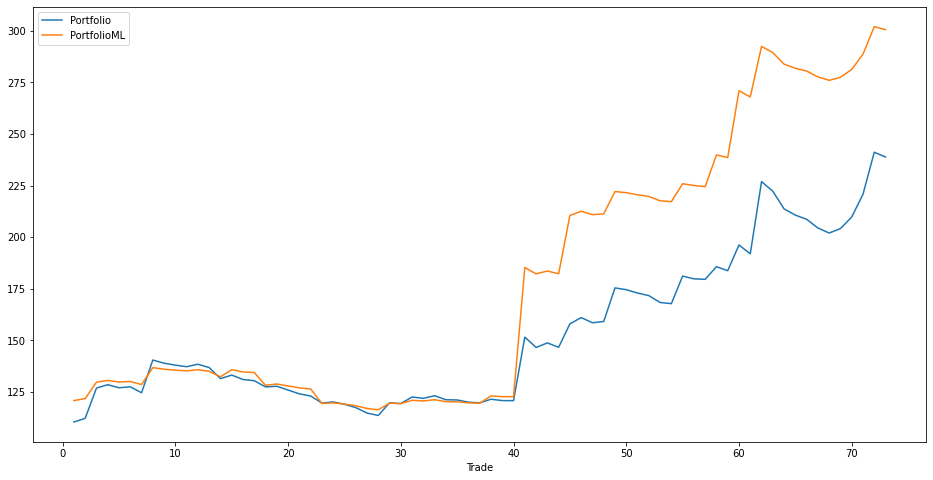

In [38]:
df[["Portfolio","PortfolioML"]].plot(figsize=(16,8))